In [150]:
import folium
from folium.features import DivIcon
import folium.plugins
import numpy as np
import random

def show_shops_map(shops, my_map=None, day=0):
    def draw_shop(shop, color, fill_opacity=0.6, radius=2, txt=''):
        lat, lon = shop["location"]
        return folium.CircleMarker(
            location=[lat, lon], 
            popup = f'name:{shop["shopname"]}\n'+txt, 
            radius = max(0.01, radius), 
            color = color, 
            fill_opacity = fill_opacity,
            weight = 1, # gruix perimetre
            fill = True,
            fill_color = color
        )

    mymap = folium.Map(location=(41.401361, 2.174317), zoom_start=13, tiles="cartodbpositron", control_scale=True)

    all_shops_group = folium.FeatureGroup('Shops', overlay=True) # Pots fer capes per filtrar a posteriori
    for _id, shop in shops.items():
        draw_shop(
            shop,
            color = 'red' if shop["n_trans"] > 0 else 'blue',
            fill_opacity = 0.1 if shop["n_trans"] > 0 else 0.3,
            radius=5, #(shop["n_trans"]**0.5716)*1.2, #formula per matenir proporcions visuals humanes
            txt=f'Transctions:{np.round(shop["n_trans"]**0.5716*1.2, 2)}',
        ).add_to(all_shops_group)

    all_shops_group.add_to(mymap)
    folium.LayerControl(collapsed=False).add_to(mymap)
    mymap.keep_in_front(all_shops_group)
    mymap.add_child(folium.plugins.Fullscreen())
    
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>day: {}</b></h3>
             '''.format(day)
    mymap.get_root().html.add_child(folium.Element(title_html))
    return mymap

In [151]:
import pandas as pd

def preprocessDF(path):
    shops = pd.read_csv(path, index_col=0)
    shops["n_trans"] = 0
    shops.n_trans = shops.n_trans.map(lambda x: random.randint(0,30))
    shops = shops.set_index(shops._id)
    shops.location = shops.location.map(lambda x: [y.strip("[ '']") for y in x.split(",")])
    shops.tags = shops.tags.map(lambda x: [y.strip("[ '']") for y in x.split(",")])
    shops_dict = shops.to_dict(orient='index')
    return shops_dict

In [152]:
import folium
from selenium import webdriver
import os
import time

def make_screenshot(m, img_name):
    m.save("index.html")
    mapUrl = 'file://{0}/{1}'.format(os.getcwd(), "index.html")
    driver = driver=webdriver.Firefox(executable_path="./geckodriver",log_path=None)
    driver.get(mapUrl)
    time.sleep(5)
    driver.save_screenshot(f'./img/{img_name}.png')
    driver.quit()

In [153]:
path = "/Users/tomas.gadea/tomasgadea/ACADEMIC/GCED/q6/PE/beco-project/backend/data_base/map/shops.csv"
shops_dict = preprocessDF(path)
m = show_shops_map(shops_dict, day=10)
#make_screenshot(m, f"{i:03d}")
m

In [6]:
import folium

loc = 'Corpus Christi'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

m = folium.Map(location=[27.783889, -97.510556],
               zoom_start=12)

m.get_root().html.add_child(folium.Element(title_html))

m.save('map-with-title.html')
m

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
df010 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u010.csv", index_col=0)
df050 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u050.csv", index_col=0)
df100 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u100.csv", index_col=0)
df150 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u150.csv", index_col=0)
df200 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u200.csv", index_col=0)
df250 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u250.csv", index_col=0)
df300 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u300.csv", index_col=0)
df350 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u350.csv", index_col=0)
df400 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u400.csv", index_col=0)
df450 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u450.csv", index_col=0)
df500 = pd.read_csv("/Users/tomas.gadea/Desktop/beco_csvs/heat-u500.csv", index_col=0)

In [134]:
matrix = (df010
          .join(df050)
          .join(df100)
          .join(df150)
          .join(df200)
          .join(df250)
          .join(df300)
          .join(df350)
          .join(df400)
          .join(df450)
          .join(df500)
         )
matrix

,10,50,100,150,200,250,300,350,400,450,500
1,1000.0,68.000000,30.333333,20.0,18.000000,13.0,9.000000,11.0,10.0,9.0,10.5
3,1000.0,26.333333,9.333333,11.0,5.333333,7.0,5.666667,3.0,5.0,3.0,2.0
5,1000.0,12.666667,4.666667,8.0,5.000000,5.0,2.666667,2.0,2.0,2.0,1.5
10,1000.0,7.000000,4.000000,5.0,1.666667,2.0,1.666667,1.0,1.0,2.0,1.0
20,1000.0,6.333333,1.333333,2.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0


In [90]:
np.log(matrix)

,10,50,100,150,200,250,300,350,400,450,500
1,6.907755,4.219508,3.412247,2.995732,2.890372,2.564949,2.197225,2.397895,2.302585,2.197225,2.351375
3,6.907755,3.270836,2.233592,2.397895,1.673976,1.945910,1.734601,1.098612,1.609438,1.098612,0.693147
5,6.907755,2.538974,1.540445,2.079442,1.609438,1.609438,0.980829,0.693147,0.693147,0.693147,0.405465
10,6.907755,1.945910,1.386294,1.609438,0.510826,0.693147,0.510826,0.000000,0.000000,0.693147,0.000000
20,6.907755,1.845827,0.287682,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [129]:
%matplotlib notebook

<IPython.core.display.Javascript object>


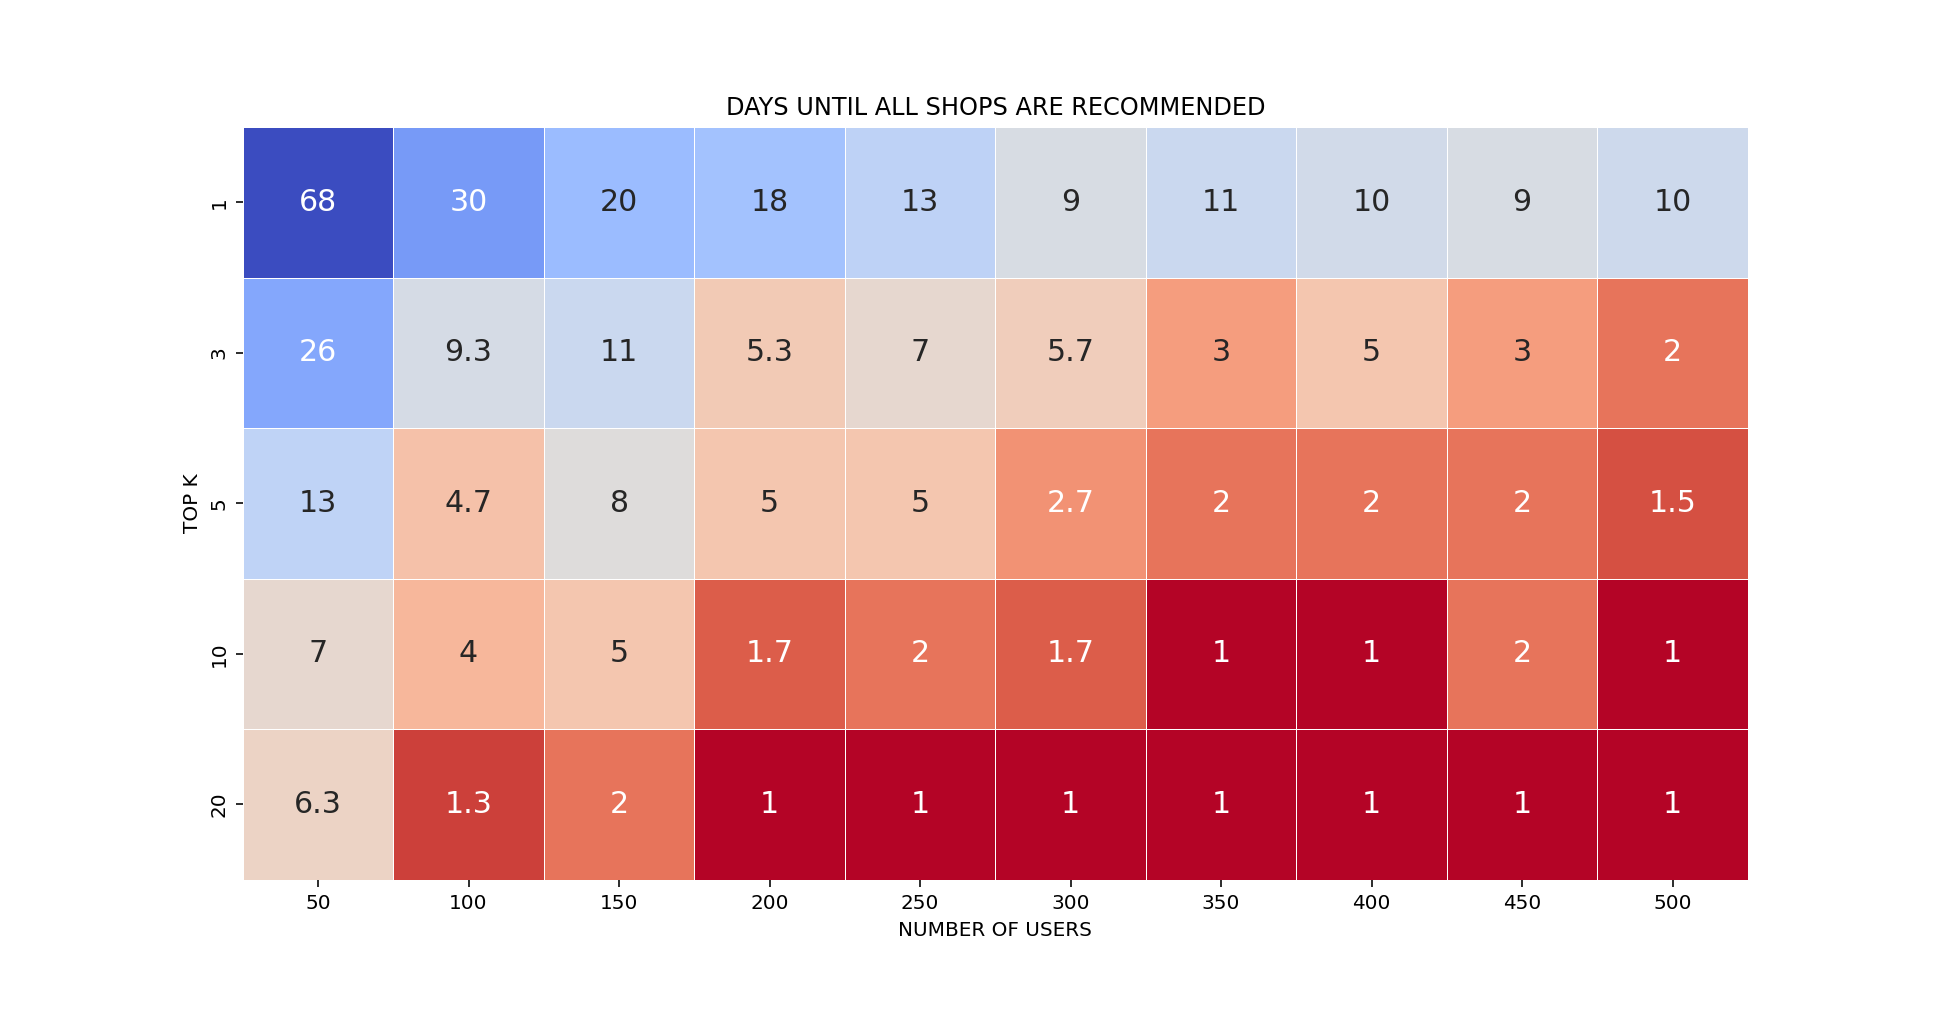

In [140]:
plt.figure(figsize=(10,5))
sns.heatmap(
    np.log(matrix.iloc[:,1:]), 
    square=True, 
    annot=matrix.iloc[:,1:], 
    linewidths=.5, 
    #cmap="RdYlGn_r", 
    cmap="coolwarm_r", 
    cbar=False,
    annot_kws={"size": 15},
)
plt.title("DAYS UNTIL ALL SHOPS ARE RECOMMENDED")
plt.xlabel("NUMBER OF USERS")
plt.ylabel("TOP K")
plt.show()

In [133]:
#matrix.to_csv("/Users/tomas.gadea/Desktop/beco_csvs/matrix.csv")